In [1]:
import pandas as pd

data_pth = "N:/Classes/2022_2FALL/Analytics Day/Data/output_df.csv"

df = pd.read_csv(data_pth)

In [3]:
### TEXT ANALYSIS PACKAGES INIT AND HYPERPARAMETER LIST

##################################################################################################################################################

from bertopic import BERTopic
import os, spacy
from umap import UMAP
from sklearn.decomposition import PCA
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from transformers.pipelines import pipeline
import nltk, time, umap, hdbscan, gc
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer


 

verbose = True
rand_state = 20221207


nn_list = [10, 25, 50, 75, 90]
nc_list = [2]
lr_list = [0.01]
md_list = [0.05]
m_list = ["cosine"] #  

min_cluster_size_list = [10]

ng_list = [(1, 1)] # [(1, 1), (1, 2), (1, 3)]
tnw_list = [10]
mts_list = [10]
nrt_list = [None] # , 10, "auto"

temp_fold_pth = "N:/Classes/2022_2FALL/Analytics/Day/topic_model/"

##################################################################################################################################################################
##################################################################################################################################################################
##################################################################################################################################################################

bertopic_list = []
docs = df["clean_rComments_tags"].tolist()

In [4]:
### BERTopic with UMAP, HDBSCAN, COUNTVECTORIZER, and CTFIDF models
##################################################################################################################################################

embedding_model_bert = pipeline(
                                "feature-extraction",
                                model = "sentence-transformers/all-mpnet-base-v2" #"distilbert-base-cased"
                               )

print("NUMBER OF UMAP MODELS CREATED:", len(nn_list)*len(nc_list)*len(lr_list)*len(md_list)*len(m_list))
umap_model_list = []
for nn in nn_list:
    for nc in nc_list:
        for lr in lr_list:
            for md in md_list:
                for m in m_list:
                    umap_model = UMAP(
                                      n_neighbors = nn,             # int 2-100, doc neighborhood
                                      n_components = nc,            # int 2-100, doc dimensionality
                                      n_epochs = 200,              # None 'or' 200 (large dataframes) 'or' 500 (small dataframes)
                                      learning_rate = lr,          # float
                                    #   init = "spectral",            # string spectral, random, pca 'or' np.array
                                      min_dist = md,               # float 0.1 (default)
                                      metric = m,             # string euclidean, manhattan, chebyshev, minkowski, canberra, braycurtis, mahalanobis, wminkowski, seuclidean, cosine, correlation, haversine, hamming, jaccard, dice, russelrao, kulsinski, ll_dirichlet, hellinger, rogerstanimoto, sokalmichener, sokalsneath, yule
                                      verbose = verbose,
                                      random_state = rand_state
                                     )
                    umap_model_list.append([umap_model, nn, nc, lr, md, m])

hdbscan_model_list = []
print("NUMBER OF HDBSCAN MODELS CREATED:", len(min_cluster_size_list))
for mcsl in min_cluster_size_list:
    hdbscan_model = HDBSCAN(
                            min_cluster_size = mcsl,                  # The minimum size of clusters; single linkage splits that contain fewer points than this will be considered points "falling out" of a cluster rather than a cluster splitting into two new clusters.
                            metric = "euclidean",
                            prediction_data = True,
                            gen_min_span_tree = True,               # Whether to generate the minimum spanning tree with regard to mutual reachability distance for later analysis.
                            # cluster_selection_method = "eom",
                            # approx_min_span_tree = True,          # Default = False
                            # allow_single_cluster = False,
                            # min_samples = None,                     # The number of samples in a neighbourhood for a point to be considered a core point.
                            # cluster_selection_epsilon = 0,
                            # max_cluster_size = 0,
                            # alpha = 1,
                            # p = None,
                            # algorithm = "best",
                            # leaf_size = 40,
                            # match_reference_implementation = False  # There exist some interpretational differences between this HDBSCAN* implementation and the original authors reference implementation in Java.
                            )
    hdbscan_model_list.append([hdbscan_model, mcsl])


vectorizer_model_list = [[CountVectorizer(ngram_range = ng, stop_words = "english"), ng] for ng in ng_list]


ctfidf_model = ClassTfidfTransformer(reduce_frequent_words = True)

print("NUMBER OF BERTopic MODELS CREATED:", len(hdbscan_model_list)*len(umap_model_list)*len(vectorizer_model_list)*len(tnw_list)*len(mts_list)*len(nrt_list))

i = 0
for hdbscan_model in hdbscan_model_list:
    for umap_model in umap_model_list:
        for vectorizer_model in vectorizer_model_list:
            for tnw in tnw_list:
                for mts in mts_list:
                    for nrt in nrt_list:
                        start_time = time.time()
                        model_nm = temp_fold_pth + "temp_user_comment" + "_topic_model_" + str(i)
                        topic_model = BERTopic(
                                            verbose = verbose,
                                            language = "english",
                                            top_n_words = tnw,
                                            min_topic_size = mts,
                                            nr_topics = nrt,
                                            low_memory = False,
                                            calculate_probabilities = True,
                                            embedding_model = embedding_model_bert,
                                            umap_model = umap_model[0],
                                            hdbscan_model = hdbscan_model[0],
                                            vectorizer_model = vectorizer_model[0],
                                            ctfidf_model = ctfidf_model,
                                            )

                        # Fit the model and predict documents
                        topics, probs = topic_model.fit_transform(docs)
                        end_time = time.time()
                        num_tops = len(topic_model.get_topic_info().Topic.tolist())

                        print("NUMBER OF TOPICS IN" + model_nm + " =", num_tops)
                        # topic_model.save(model_nm)

                        bertopic_list.append([i, "USER COMMENTS", num_tops, model_nm, start_time, end_time] + umap_model[1:] + hdbscan_model[1:] + vectorizer_model[1:])

                        i = i + 1
                        del topic_model
                        gc.collect()

bertopic_df = pd.DataFrame(bertopic_list, columns = ["index", "col_name", "num_tops", "model_nm", "start_time", "end_time", "near_neighbor", "num_components", "learn_rate", "min_dist", "metric", "min_clust_size", "n_gram"])

NUMBER OF UMAP MODELS CREATED: 5
NUMBER OF HDBSCAN MODELS CREATED: 1
NUMBER OF BERTopic MODELS CREATED: 5


100%|██████████| 286334/286334 [5:34:35<00:00, 14.26it/s]  
2022-11-06 01:38:56,786 - BERTopic - Transformed documents to Embeddings


UMAP(angular_rp_forest=True, learning_rate=0.01, metric='cosine', min_dist=0.05, n_epochs=500, n_neighbors=10, random_state=20221207, verbose=True)
Sun Nov  6 01:38:57 2022 Construct fuzzy simplicial set
Sun Nov  6 01:38:57 2022 Finding Nearest Neighbors
Sun Nov  6 01:38:57 2022 Building RP forest with 32 trees
Sun Nov  6 01:39:12 2022 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	 5  /  18
	 6  /  18
	 7  /  18
	 8  /  18
	Stopping threshold met -- exiting after 8 iterations
Sun Nov  6 01:39:27 2022 Finished Nearest Neighbor Search
Sun Nov  6 01:39:29 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Nov  6 01:45:25 2022 Finished embedding


2022-11-06 01:45:27,993 - BERTopic - Reduced dimensionality


In [4]:
def remove_urls(text):
    import re
    " removes urls"
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    links_lst = re.findall(url_pattern, text)
    return re.sub(url_pattern, "", text), links_lst # URL_MASK
    
def remove_parentheses(text):
    import re
    " removes parentheses"
    para_pattern = re.compile(r'\(.*?\)')
    para_lst = [re.sub("[\\(\\)]", "", x).strip() for x in re.findall(para_pattern, text)]
    return re.sub(para_pattern, "", text), para_lst # PARENTHESES_MASK
    
def remove_html(text):
    import re
    " removes html tags"
    html_pattern = re.compile('')
    return html_pattern.sub(r'', text)

def remove_new_line(text):
    import re
    return re.sub(r"\\\n", ' ', text)

def remove_non_alpha(text):
    import re
    return re.sub("[^A-Za-z0-9\\.\\_]+", ' ', str(text))

def fix_these_data(text, fix_lst):
    import re
    if text[0] != " ":
        text = " " + text
    if text[-1] != " ":
        text = text + " "
    
    for x in fix_lst:
        text = re.sub(x[0], x[1], text)
    text = re.sub("\\(", " ( ", text)
    text = re.sub("\\)", " ) ", text)
    text = re.sub("\\.\\\n", " ", text)
    text = re.sub("\\\"", " ", text)
    text = re.sub("\\\'", " ", text)
    text = re.sub(" +", " ", text)
    return text.strip()

def remove_extra_periods(text):
    import re
    pat = re.compile('\\.')
    txt_lst = re.sub(pat, " NJ3CT_H3R3 ", text).split("NJ3CT_H3R3")
    hodl_string = " ".join(txt_lst)
    
    if len(txt_lst) > 1:
        temp_lst = []
        hodl_string = ""
        for txt_part in txt_lst:
            txt_part = txt_part.strip()
            if len(txt_part) > 0:
                if txt_part[0] == txt_part[0].lower():
                    hodl_string = hodl_string + " " + txt_part
                else:
                    hodl_string = hodl_string + ". " + txt_part
                    if hodl_string[0] == ".":
                        hodl_string = hodl_string[1:]
    return hodl_string.strip()

def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords])


def preprocess_text(t): #[" UK ", " United Kingdom "], [" U\\.K\\. ", " United Kingdom "], [" U\\. K\\. ", " United Kingdom "], [" U K ", " United Kingdom "], [" U\\. S\\. ", " United States "], [" US ", " United States "], [" U S ", " United States "], [" U\\.S\\. ", " United States "], 
    import re
    # contraction_lst = [[" can\\\'t ",  " can not "], [" let\\\'s ",  " let us "], [" won\\\'t ",  " will not "], [" n\\\'t ",  "  not "], [" \\\'m ",  "  am "], [" \\\'s ",  "  is "], [" \\\'re ",  "  are "], [" \\\'ve ",  "  have "], [" \\\'d ",  "  had "], [" \\\'ll ",  "  will "], [" arent ",  " are not "], [" cant ",  " cannot "], [" couldnt ",  " could not "], [" didnt ",  " did not "], [" doesnt ",  " does not "], [" dont ",  " do not "], [" hadnt ",  " had not "], [" hasnt ",  " has not "], [" havent ",  " have not "], [" hed ",  " he had "], [" hes ",  " he is "], [" Id ",  " I would "], [" Ill ",  " I will "], [" Im ",  " I am "], [" Ive ",  " I have "], [" isnt ",  " is not "], [" lets ",  " let us "], [" mightnt ",  " might not "], [" mustnt ",  " must not "], [" shant ",  " shall not "], [" shed ",  " she had "], [" shes ",  " she is "], [" shouldnt ",  " should not "], [" thats ",  " that is "], [" theres ",  " there is "], [" theyd ",  " they had "], [" theyll ",  " they will "], [" theyre ",  " they are "], [" theyve ",  " they have "], [" wed ",  " we had "], [" were ",  " we are "], [" weve ",  " we have "], [" werent ",  " were not "], [" whatll ",  " what will "], [" whatre ",  " what are "], [" whats ",  " what is "], [" whatve ",  " what have "], [" wheres ",  " where is "], [" whod ",  " who had "], [" wholl ",  " who will "], [" whore ",  " who are "], [" whos ",  " who is "], [" whove ",  " who have "], [" wont ",  " will not "], [" wouldnt ",  " would not "], [" youd ",  " you had "], [" youll ",  " you will "], [" youre ",  " you are "], [" youve ",  " you have "]]
    contraction_lst = [[" cant ",  " can not "], [" lets ",  " let us "], [" wont ",  " will not "], [" nt ",  "  not "], [" m ",  "  am "], [" s ",  "  is "], [" re ",  "  are "], [" ve ",  "  have "], [" d ",  "  had "], [" ll ",  "  will "], [" arent ",  " are not "], [" cant ",  " cannot "], [" couldnt ",  " could not "], [" didnt ",  " did not "], [" doesnt ",  " does not "], [" dont ",  " do not "], [" hadnt ",  " had not "], [" hasnt ",  " has not "], [" havent ",  " have not "], [" hed ",  " he had "], [" hes ",  " he is "], [" Id ",  " I would "], [" Ill ",  " I will "], [" Im ",  " I am "], [" Ive ",  " I have "], [" isnt ",  " is not "], [" lets ",  " let us "], [" mightnt ",  " might not "], [" mustnt ",  " must not "], [" shant ",  " shall not "], [" shed ",  " she had "], [" shes ",  " she is "], [" shouldnt ",  " should not "], [" thats ",  " that is "], [" theres ",  " there is "], [" theyd ",  " they had "], [" theyll ",  " they will "], [" theyre ",  " they are "], [" theyve ",  " they have "], [" wed ",  " we had "], [" were ",  " we are "], [" weve ",  " we have "], [" werent ",  " were not "], [" whatll ",  " what will "], [" whatre ",  " what are "], [" whats ",  " what is "], [" whatve ",  " what have "], [" wheres ",  " where is "], [" whod ",  " who had "], [" wholl ",  " who will "], [" whore ",  " who are "], [" whos ",  " who is "], [" whove ",  " who have "], [" wont ",  " will not "], [" wouldnt ",  " would not "], [" youd ",  " you had "], [" youll ",  " you will "], [" youre ",  " you are "], [" youve ",  " you have "]]
    t = re.sub(r"'", "", t)
    t = fix_these_data(t, contraction_lst)
    t, link_lst = remove_urls(t)
    t, para_lst = remove_parentheses(t)
    t = remove_extra_periods(t)
    t = remove_html(t)
    t = remove_new_line(t)
    t = remove_non_alpha(t)
    t = remove_stopwords(t)
    t = lemmatize_words(t)
    return t.strip()

#################################################################


In [21]:
import pandas as pd
from transformers import pipeline
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stopwords = stopwords.words("english")

data_pth = "N:/Classes/2022_2FALL/Analytics Day/Data/output_df.csv"


df = pd.read_csv(data_pth).iloc[0:100]


df["reviews"] = df["rComments"]

In [22]:
# USE IT LIKE THIS
df["clean_reviews"] = [preprocess_text(text) for text in df["reviews"]]



In [ ]:
pip install matplotlib
pip install pandas
pip install wordcloud
pip install transformers
pip install nltk

In [23]:
df["clean_reviews_word_list"] = [text.replace("\\.", "").lower().split(" ") for text in df["clean_reviews"]]
word_cloud_input = " ".join([x for x_list in df["clean_reviews_word_list"].tolist() for x in x_list])

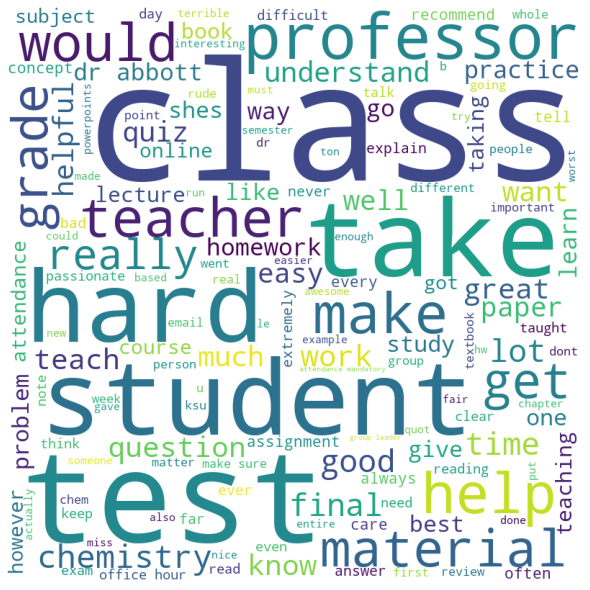

In [26]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 800, 
                      height = 800,
                      background_color ='white',
                      stopwords = stopwords,
                      min_font_size = 10
                     )

wordcloud.generate(word_cloud_input)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()